In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomZoom
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Set the path to the split dataset directory
split_dataset_dir = '/content/drive/MyDrive/Dataset_divided'


In [4]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
])




In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation Configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

# Assuming your data is divided into 'train' and 'valid' directories within 'split_dataset_dir'
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_dir, 'valid'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)




Found 7350 images belonging to 4 classes.
Found 1578 images belonging to 4 classes.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the VGG16 model without the top layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Get the output after the 3rd layer of the VGG16 model
model_output = base_model.layers[3].output

# Define the custom layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(model_output)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)


predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Specify the path and filename for saving the model
model_save_path = '/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5'

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1)
]

# Data Augmentation Configuration
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])



In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                           

In [17]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 1.6434 - accuracy: 0.4894 
Epoch 1: val_loss improved from inf to 0.97975, saving model to /content/drive/MyDrive/saved_model/Final_VGG16_Model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 3231s 14s/step - loss: 1.6434 - accuracy: 0.4894 - val_loss: 0.9797 - val_accuracy: 0.5634
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.6499
Epoch 2: val_loss improved from 0.97975 to 0.68506, saving model to /content/drive/MyDrive/saved_model/Final_VGG16_Model.h5
230/230 [==============================] - 68s 294ms/step - loss: 0.7840 - accuracy: 0.6499 - val_loss: 0.6851 - val_accuracy: 0.6869
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.6944
Epoch 3: val_loss did not improve from 0.68506
230/230 [==============================] - 64s 280ms/step - loss: 0.6886 - accuracy: 0.6944 - val_loss: 0.7296 - val_accuracy: 0.6882
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.7146
Epoch 4: val_loss improved from 0.68506 to 0.59646, saving model to /content/drive/MyDrive/saved_model/Final_VGG16_Model.h5
230/230 [======

In [27]:

# Save the entire model to a HDF5 file
model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')



In [28]:
# Load the model from the HDF5 file
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')


In [29]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')

In [30]:
model_evaluate = model.evaluate(validation_generator)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

50/50 [==============================] - 10s 208ms/step - loss: 0.2035 - accuracy: 0.9170
Accuracy: % 91.70
Loss: % 20.35


In [31]:

# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')

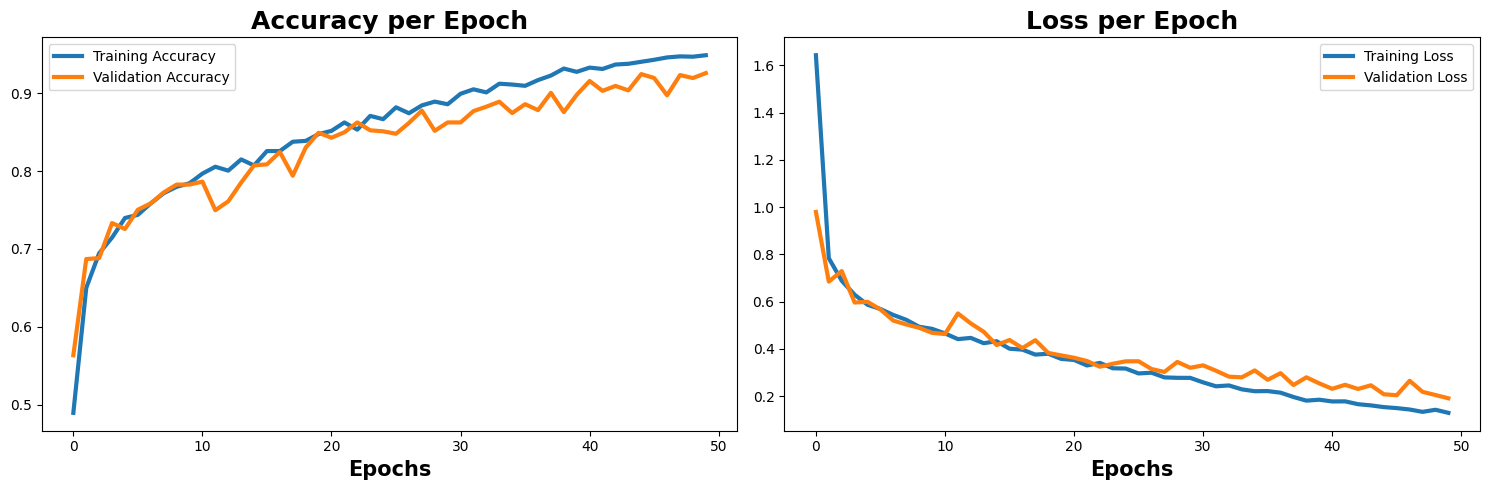

In [32]:
df = pd.DataFrame(history.history)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(df['accuracy'], label='Training Accuracy', lw=3)
ax1.plot(df['val_accuracy'], label='Validation Accuracy', lw=3)
ax1.set_title('Accuracy per Epoch', fontsize=18, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax1.legend()

# Plot loss
ax2.plot(df['loss'], label='Training Loss', lw=3)
ax2.plot(df['val_loss'], label='Validation Loss', lw=3)
ax2.set_title('Loss per Epoch', fontsize=18, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

[]

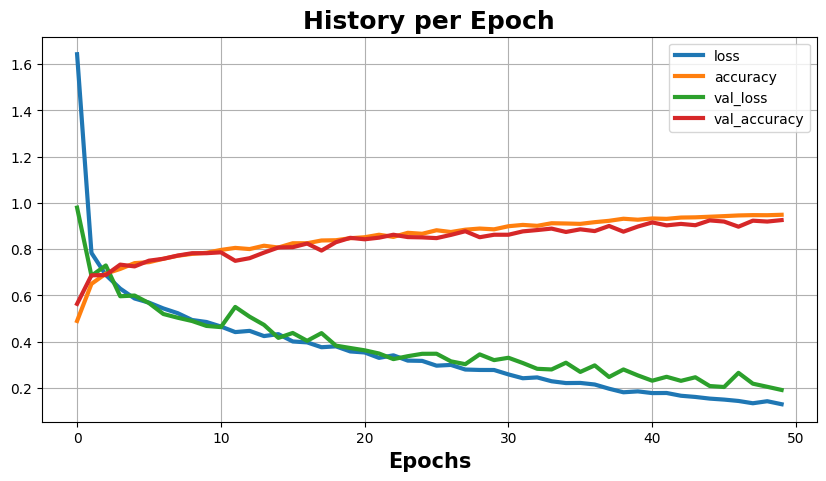

In [33]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
import pandas as pd
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [34]:
# Save the entire model to Google Drive
loaded_model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


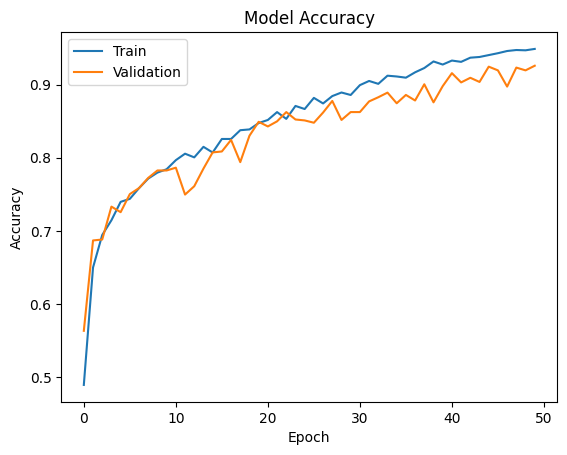

In [35]:

# Visualize Training History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
# Save the entire model to a HDF5 file
loaded_model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')


Found 1574 images belonging to 4 classes.
50/50 [==============================] - 11s 217ms/step
Overall Metrics:
Accuracy: 0.9155
Precision: 0.9167
Recall: 0.9155
F1-score: 0.9156


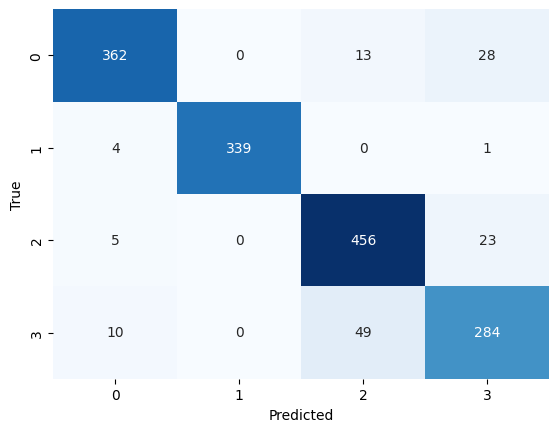

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Make predictions on the test data
test_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_dir, 'test'),
    target_size=(128, 128),
    batch_size=32,  # Set batch size to 32
    class_mode='categorical',
    shuffle=False,  # Don't shuffle to match predictions with true labels
    seed=1  # Set seed to 1
)

y_true = test_generator.classes  # True labels
y_pred_probs = loaded_model.predict(test_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Calculate overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [41]:
# Save the updated model with the same name
loaded_model.save('/content/drive/MyDrive/saved_model/Final_VGG16_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
